# Marketing Campaign Analysis

Reviews retrieved from the following Kaggle [dataset](https://www.kaggle.com/rodsaldanha/arketing-campaign).

### 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Load Data

In [2]:
data = pd.read_csv("data.csv", delimiter=";")

In [3]:
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


### 2. Exploratory Data Analysis and Data Cleaning

Let's analyse some of the client's features (i.e. year of birth, education, marital status and income) and analyse the correlation between them and the campaign acceptance.

#### 2.1. Check for missing data

In [4]:
print('Missing data [%]')
round(data.isnull().sum() / len(data) * 100, 4)

Missing data [%]


ID                     0.0000
Year_Birth             0.0000
Education              0.0000
Marital_Status         0.0000
Income                 1.0714
Kidhome                0.0000
Teenhome               0.0000
Dt_Customer            0.0000
Recency                0.0000
MntWines               0.0000
MntFruits              0.0000
MntMeatProducts        0.0000
MntFishProducts        0.0000
MntSweetProducts       0.0000
MntGoldProds           0.0000
NumDealsPurchases      0.0000
NumWebPurchases        0.0000
NumCatalogPurchases    0.0000
NumStorePurchases      0.0000
NumWebVisitsMonth      0.0000
AcceptedCmp3           0.0000
AcceptedCmp4           0.0000
AcceptedCmp5           0.0000
AcceptedCmp1           0.0000
AcceptedCmp2           0.0000
Complain               0.0000
Z_CostContact          0.0000
Z_Revenue              0.0000
Response               0.0000
dtype: float64

As we can see, the dataset is doesn't have a lot of missing data, mostly income, which is understable, as it is a sensitive information.

In [5]:
data["Income"] = data["Income"].fillna(0)

Let's add a column that specifies if the client has accepted any campaign (0 if none of them were accepted).

In [6]:
conditions = [
    (data["AcceptedCmp1"] == 1) |
    (data["AcceptedCmp2"] == 1) |
    (data["AcceptedCmp3"] == 1) |
    (data["AcceptedCmp4"] == 1) |
    (data["AcceptedCmp5"] == 1) |
    (data["Response"] == 1)
]

data['AcceptedAnyCmp'] = np.select(conditions, [1], default=0)

data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,AcceptedAnyCmp
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,3,11,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,3,11,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,3,11,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,0,3,11,0,0


#### 2.2. Date of Birth Analysis

In [7]:
print(f"Number of clients: {data.ID.nunique()}")

Number of clients: 2240


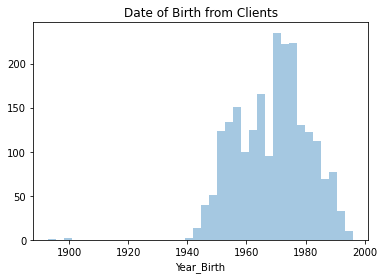

In [8]:
sns.distplot(data["Year_Birth"], kde=False, label="Age").set_title("Date of Birth from Clients")
plt.show()

As we can see, there are a few outliers, which were born before 1940. I don't believe that these clients are very relevant for this study, so they will be removed.

In [9]:
outliers = sum(data["Year_Birth"] < 1935)
print(f"There seem to be {outliers} people that were born before 1935.")

There seem to be 3 people that were born before 1935.


In [10]:
data = data.drop(data[data["Year_Birth"] < 1935].index)

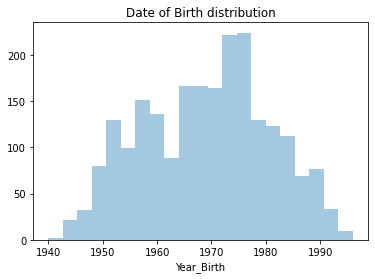

In [11]:
sns.distplot(data["Year_Birth"], kde=False, label="Age").set_title("Date of Birth distribution")
plt.show()

#### 2.3. Education Analysis

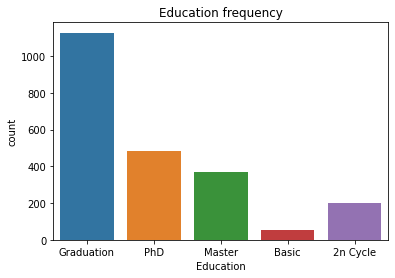

In [12]:
sns.countplot(x=data["Education"]).set_title("Education frequency")
plt.show()

The majority of clients seem to be graduates, followed by a significant portion of clients with a PhD and MSc.

#### 2.4. Martial Status Analysis

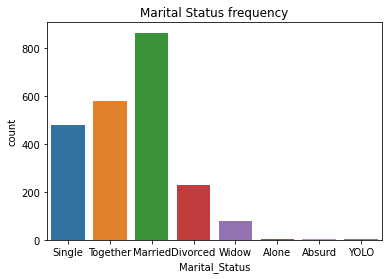

In [13]:
sns.countplot(x=data["Marital_Status"], label="Marital Status").set_title("Marital Status frequency")
plt.show()

There seem to be a few marital status that don't really make sense in the scope of this study, so they should be ignored.

In [14]:
ignored_status = ["Alone", "Absurd", "YOLO"]
outliers = sum(data["Marital_Status"].isin(ignored_status))
print(f"There seem to be {outliers} people with a marital status that should be ignored.")

There seem to be 7 people with a marital status that should be ignored.


In [15]:
data = data.drop(data[data["Marital_Status"].isin(ignored_status)].index)

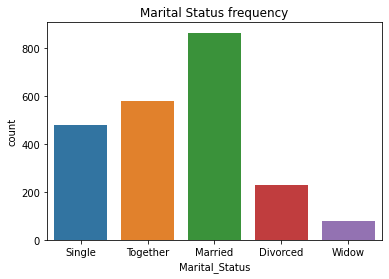

In [16]:
sns.countplot(x=data["Marital_Status"], label="Marital Status").set_title("Marital Status frequency")
plt.show()

#### 2.5. Annual Income Analysis

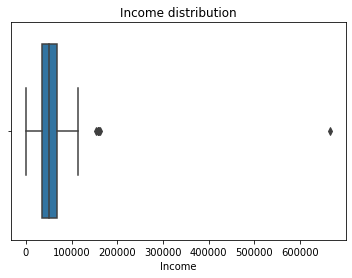

In [17]:
sns.boxplot(x=data["Income"]).set_title("Income distribution")
plt.show()

There seem to be a few outliers with an annual income higher than 100k. For this study, these outliers will not be taken into consideration.

In [18]:
outliers = sum(data["Income"] > 125000)
print(f"There seem to be {outliers} people with an annual income higher than 100k.")

There seem to be 8 people with an annual income higher than 100k.


In [19]:
data = data.drop(data[data["Income"] > 125000].index)

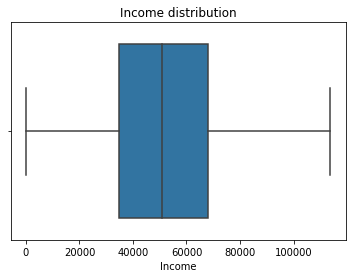

In [20]:
sns.boxplot(x=data["Income"]).set_title("Income distribution")
plt.show()

#### 2.6. Feature Correlation Analysis

In [21]:
# Convert categorical features into a type that can be correlated
data["Education"] = data["Education"].astype('category')
data["Education"].cat.categories = [0,1,2,3,4]
data["Education"] = data["Education"].astype('float')

data["Marital_Status"] = data["Marital_Status"].astype('category')
data["Marital_Status"].cat.categories = [0,1,2,3,4]
data["Marital_Status"] = data["Marital_Status"].astype('float')

In [22]:
# Get correlation
cor = data.corr()

#Correlation with output variable
cor_target = abs(cor["AcceptedAnyCmp"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > 0.15]
relevant_features.sort_values(ascending=False)

AcceptedAnyCmp         1.000000
Response               0.683983
AcceptedCmp4           0.466047
AcceptedCmp3           0.458460
AcceptedCmp5           0.456932
AcceptedCmp1           0.428764
MntWines               0.423647
NumCatalogPurchases    0.326071
MntMeatProducts        0.313423
Income                 0.295541
NumWebPurchases        0.214553
AcceptedCmp2           0.191257
MntGoldProds           0.187027
Kidhome                0.168948
MntSweetProducts       0.162697
MntFishProducts        0.161314
NumStorePurchases      0.152489
Name: AcceptedAnyCmp, dtype: float64

Looks like a client's income has a relatively high correlation with the campaign acceptance. On the other hand, the client's education, marital status and year of birth doesn't seem to have much of an impact on the campaign acceptance.

### 3. Campaign Success Analysis

In this section, a quick analysis of each campaign is made, analysing the same features that were analysed before. This way, we can check if there are specific types of customers that accepted each of the campaigns.

#### 3.1. General Campaign Performance Analysis

In [23]:
accepted_1 = len(data[data["AcceptedCmp1"] == 1].index)
accepted_2 = len(data[data["AcceptedCmp2"] == 1].index)
accepted_3 = len(data[data["AcceptedCmp3"] == 1].index)
accepted_4 = len(data[data["AcceptedCmp4"] == 1].index)
accepted_5 = len(data[data["AcceptedCmp5"] == 1].index)
accepted_6 = len(data[data["Response"] == 1].index)
accepted_any = len(data[data["AcceptedAnyCmp"] == 1].index)
accepted_none = len(data[data["AcceptedAnyCmp"] == 0].index)
complained = data.Complain.sum()

print(f"Number of clients that accepted the 1st campaign: {accepted_1}")
print(f"Number of clients that accepted the 2nd campaign: {accepted_2}")
print(f"Number of clients that accepted the 3rd campaign: {accepted_3}")
print(f"Number of clients that accepted the 4th campaign: {accepted_4}")
print(f"Number of clients that accepted the 5th campaign: {accepted_5}")
print(f"Number of clients that accepted the 6th campaign: {accepted_6}")
print(f"Number of clients that have accepted a campaign: {accepted_any}")
print(f"Number of clients that didn't accept any campaigns: {accepted_none}")
print(f"Number of clients that complained in the last 2 years: {complained}")

Number of clients that accepted the 1st campaign: 143
Number of clients that accepted the 2nd campaign: 30
Number of clients that accepted the 3rd campaign: 162
Number of clients that accepted the 4th campaign: 167
Number of clients that accepted the 5th campaign: 161
Number of clients that accepted the 6th campaign: 331
Number of clients that have accepted a campaign: 605
Number of clients that didn't accept any campaigns: 1617
Number of clients that complained in the last 2 years: 20


#### 3.2. First Campaign Analysis

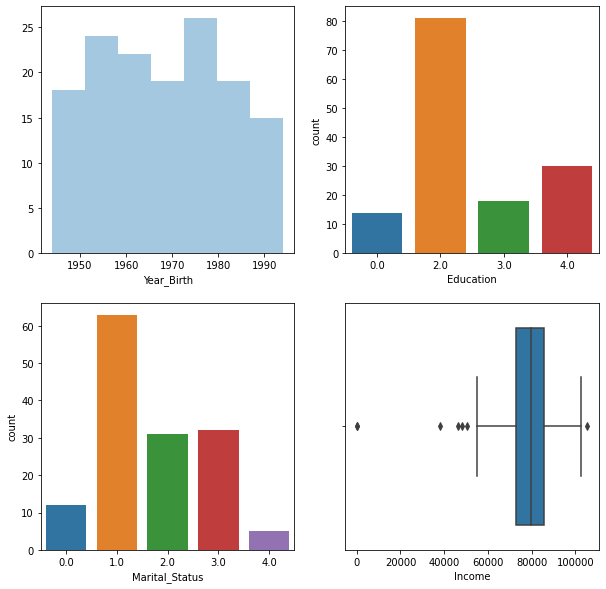

In [24]:
first_c = data[data.AcceptedCmp1 == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(first_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=first_c["Education"], ax=axes[0][1])
sns.countplot(x=first_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=first_c["Income"], ax=axes[1][1])

plt.show()

#### 3.3. Second Campaign Analysis

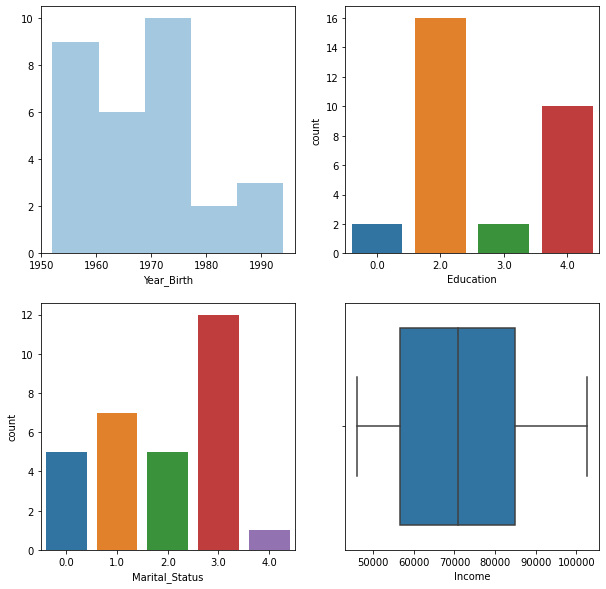

In [25]:
second_c = data[data.AcceptedCmp2 == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(second_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=second_c["Education"], ax=axes[0][1])
sns.countplot(x=second_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=second_c["Income"], ax=axes[1][1])

plt.show()

#### 3.4. Third Campaign Analysis

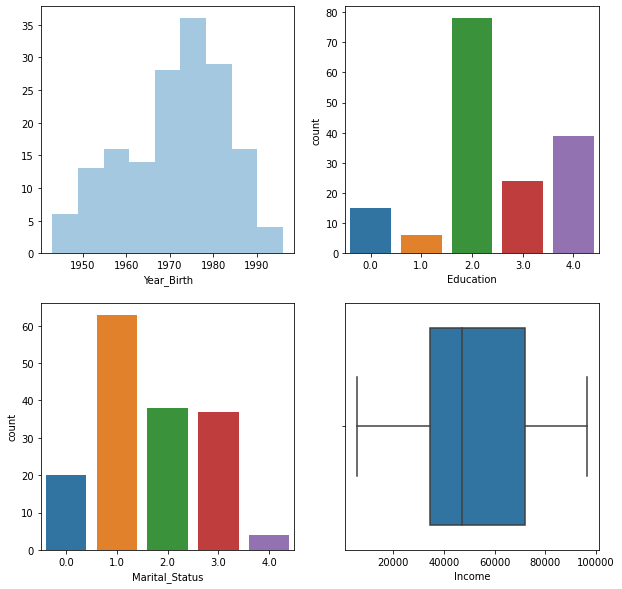

In [26]:
third_c = data[data.AcceptedCmp3 == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(third_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=third_c["Education"], ax=axes[0][1])
sns.countplot(x=third_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=third_c["Income"], ax=axes[1][1])

plt.show()

#### 3.5. Fourth Campaign Analysis

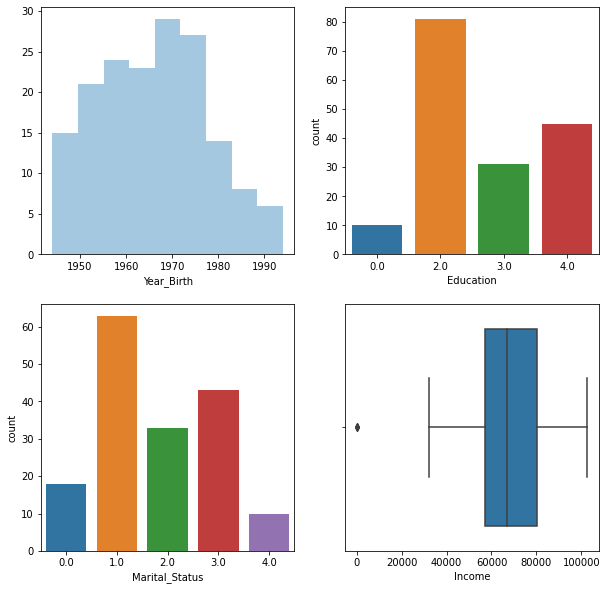

In [27]:
fourth_c = data[data.AcceptedCmp4 == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(fourth_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=fourth_c["Education"], ax=axes[0][1])
sns.countplot(x=fourth_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=fourth_c["Income"], ax=axes[1][1])

plt.show()

#### 3.6. Fifth Campaign Analysis

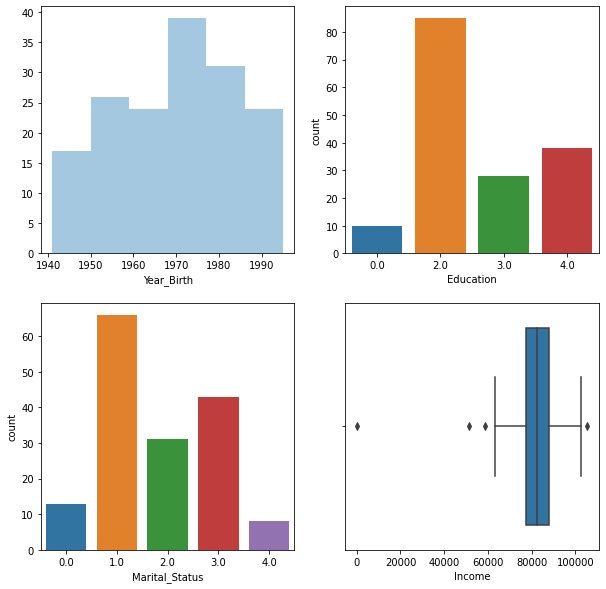

In [28]:
fifth_c = data[data.AcceptedCmp5 == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(fifth_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=fifth_c["Education"], ax=axes[0][1])
sns.countplot(x=fifth_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=fifth_c["Income"], ax=axes[1][1])

plt.show()

#### 3.7. Sixth Campaign Analysis

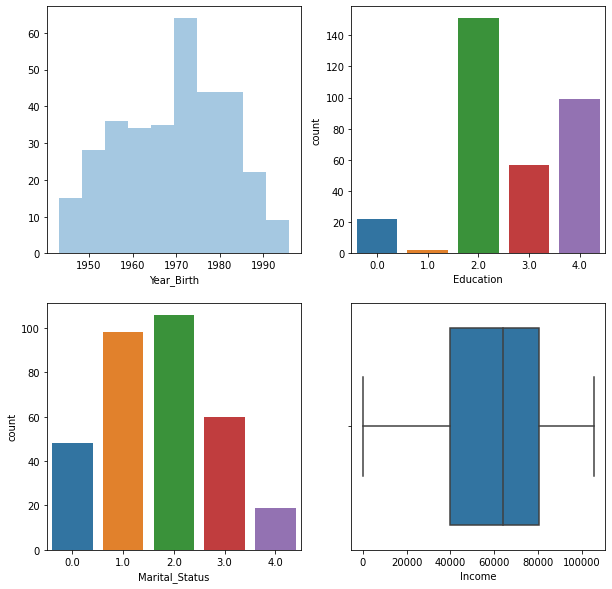

In [29]:
sixth_c = data[data.Response == 1]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(sixth_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=sixth_c["Education"], ax=axes[0][1])
sns.countplot(x=sixth_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=sixth_c["Income"], ax=axes[1][1])

plt.show()

#### 3.8. Clients that didn't accept any Campaign Analysis

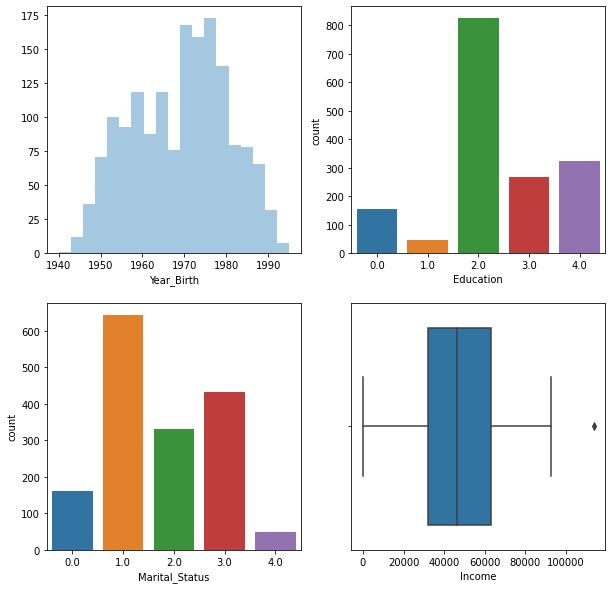

In [30]:
none_c = data[data.AcceptedAnyCmp == 0]

f, axes = plt.subplots(2, 2, figsize=(10,10))

sns.distplot(none_c["Year_Birth"], kde=False, label="Age", ax=axes[0][0])
sns.countplot(x=none_c["Education"], ax=axes[0][1])
sns.countplot(x=none_c["Marital_Status"], label="Marital Status", ax=axes[1][0])
sns.boxplot(x=none_c["Income"], ax=axes[1][1])

plt.show()

All in all, the 3rd and 6th campaign seem to be the campaigns with the broadest reach.

On the other hand, the income seems to be a feature that varies quite a bit from campaign to campaign, which may indicate that some of the campaigns may be more well-suited to a higher range of annual incomes than others, and vice versa. For instance, the 2nd campaign seemed to be more accepted by people with an annual income of 50k+.

### 4. Campaign Acceptance Predictor

#### 4.1. Relevant Feature Selection

Based on the following [article](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b).

In [31]:
# Select the most relevant features
X = data.loc[:, "Year_Birth":"Teenhome"].join(data.loc[:, "Recency":"NumWebVisitsMonth"])
y = data["AcceptedAnyCmp"]

reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 2.800887
Best score using built-in LassoCV: 0.186553


In [32]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 15 variables


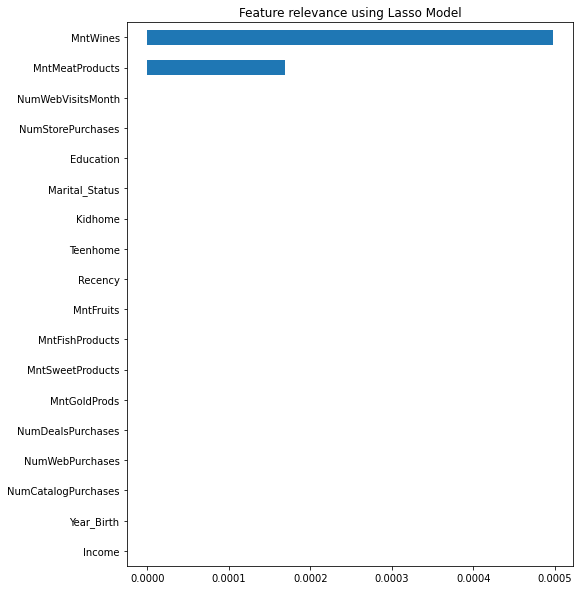

In [33]:
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature relevance using Lasso Model")
plt.show()

In [34]:
coef != 0

Year_Birth             False
Education              False
Marital_Status         False
Income                  True
Kidhome                False
Teenhome               False
Recency                False
MntWines                True
MntFruits              False
MntMeatProducts         True
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
dtype: bool

Looks like the income, amount spent on wines and meat are the most relevant features to predict the campaign acceptance.

#### 4.2. Train/Test Sets Split

In [35]:
X = data[["Income", "MntWines", "MntMeatProducts"]]

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

#### 4.3. Train Model

In [36]:
from sklearn.naive_bayes import GaussianNB

clf_nb = GaussianNB()

clf_nb.fit(X_train, y_train)

GaussianNB()

#### 4.4. Evaluate Model

In [37]:
acc = clf_nb.score(X_test, y_test)
f1 = f1_score(y_test, clf_nb.predict(X_test), average=None, labels=[0,1])

print(f"Accuracy: {acc:.4f}")
print(f"F1-Score (Rejected): {f1[0]:.4f}")
print(f"F1-Score (Accepted): {f1[1]:.4f}")

Accuracy: 0.7779
F1-Score (Rejected): 0.8478
F1-Score (Accepted): 0.5894


The obtained model performed rather well in the evaluation, although further improvements can be made. 

For instance, in the following code block, it is shown that the ammount of rejected campaigns is way higher than the accepted campaigns, in both sets, which may result in a certain bias towards the rejected campaigns, as shown by the F1-scores. 

If the ammount of accepted and reject campaigns is evened out, it's likely that the model will perform better in the evaluation, as it isn't biased towards the rejected campaigns.

In [38]:
# Check if the number of labels is even in both sets
train_count = y_train.value_counts(normalize=True)
test_count = y_test.value_counts(normalize=True)

print("Label counts in Training Set:\n", train_count, "\n")
print("Label counts in Test Set:\n", test_count)

Label counts in Training Set:
 0    0.739919
1    0.260081
Name: AcceptedAnyCmp, dtype: float64 

Label counts in Test Set:
 0    0.702997
1    0.297003
Name: AcceptedAnyCmp, dtype: float64


### 5. Market Segmentation (Clustering)

Based on the following [video](https://www.youtube.com/watch?v=4jv1pUrG0Zk).